In [1]:
# Import the needed libraries
import numpy as np
import pymc3 as pm
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import arviz as az
import seaborn as sns
sns.set(rc={'figure.figsize':(12,8)})
sns.set_theme()

from IPython.display import display, Markdown
az.style.use('arviz-darkgrid')
np.random.seed(44)

from scipy.stats import halfnorm

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


# Import the data

In [2]:
# Import two datasets containing the required data
df = pd.read_csv("./Data/titles.csv")
df2 = pd.read_csv("./Data/credits.csv")

In [3]:
df.head()

,id,title,type,description,release_year,age_certification,runtime,genres,production_countries,seasons,imdb_id,imdb_score,imdb_votes,tmdb_popularity,tmdb_score
0,ts300399,Five Came Back: The Reference Films,SHOW,This collection includes 12 World War II-era p...,1945,TV-MA,51,['documentation'],['US'],1.0,NaN,NaN,NaN,0.600,NaN
1,tm84618,Taxi Driver,MOVIE,A mentally unstable Vietnam War veteran works ...,1976,R,114,"['drama', 'crime']",['US'],NaN,tt0075314,8.2,808582.0,40.965,8.179
2,tm154986,Deliverance,MOVIE,Intent on seeing the Cahulawassee River before...,1972,R,109,"['drama', 'action', 'thriller', 'european']",['US'],NaN,tt0068473,7.7,107673.0,10.010,7.300
3,tm127384,Monty Python and the Holy Grail,MOVIE,"King Arthur, accompanied by his squire, recrui...",1975,PG,91,"['fantasy', 'action', 'comedy']",['GB'],NaN,tt0071853,8.2,534486.0,15.461,7.811
4,tm120801,The Dirty Dozen,MOVIE,12 American military prisoners in World War II...,1967,NaN,150,"['war', 'action']","['GB', 'US']",NaN,tt0061578,7.7,72662.0,20.398,7.600


In [4]:
df2.head()

,person_id,id,name,character,role
0,3748,tm84618,Robert De Niro,Travis Bickle,ACTOR
1,14658,tm84618,Jodie Foster,Iris Steensma,ACTOR
2,7064,tm84618,Albert Brooks,Tom,ACTOR
3,3739,tm84618,Harvey Keitel,Matthew 'Sport' Higgins,ACTOR
4,48933,tm84618,Cybill Shepherd,Betsy,ACTOR


In [5]:
# Merge the two datasets
netflix = pd.merge(df, df2[df2["role"] == "DIRECTOR"], on=["id"])
netflix.head()

,id,title,type,description,release_year,age_certification,runtime,genres,production_countries,seasons,imdb_id,imdb_score,imdb_votes,tmdb_popularity,tmdb_score,person_id,name,character,role
0,tm84618,Taxi Driver,MOVIE,A mentally unstable Vietnam War veteran works ...,1976,R,114,"['drama', 'crime']",['US'],NaN,tt0075314,8.2,808582.0,40.965,8.179,3308,Martin Scorsese,NaN,DIRECTOR
1,tm154986,Deliverance,MOVIE,Intent on seeing the Cahulawassee River before...,1972,R,109,"['drama', 'action', 'thriller', 'european']",['US'],NaN,tt0068473,7.7,107673.0,10.010,7.300,17727,John Boorman,NaN,DIRECTOR
2,tm127384,Monty Python and the Holy Grail,MOVIE,"King Arthur, accompanied by his squire, recrui...",1975,PG,91,"['fantasy', 'action', 'comedy']",['GB'],NaN,tt0071853,8.2,534486.0,15.461,7.811,11475,Terry Jones,NaN,DIRECTOR
3,tm127384,Monty Python and the Holy Grail,MOVIE,"King Arthur, accompanied by his squire, recrui...",1975,PG,91,"['fantasy', 'action', 'comedy']",['GB'],NaN,tt0071853,8.2,534486.0,15.461,7.811,11473,Terry Gilliam,NaN,DIRECTOR
4,tm120801,The Dirty Dozen,MOVIE,12 American military prisoners in World War II...,1967,NaN,150,"['war', 'action']","['GB', 'US']",NaN,tt0061578,7.7,72662.0,20.398,7.600,1063,Robert Aldrich,NaN,DIRECTOR


In [6]:
# Drop unwanted features and rename 'name' into 'director'
netflix.drop(["person_id", 'role', 'character'], inplace=True, axis=1)
netflix.rename(columns={'name': 'director'}, inplace=True)

In [7]:
# Check for null values  in the data
netflix.info()

# Just 'seasons' contain a considerable amount of null values, but it is fine as films do not have information on the season, 
# and tv shows of 1 season also do not have info on the seasons number.

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4550 entries, 0 to 4549
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    4550 non-null   object 
 1   title                 4549 non-null   object 
 2   type                  4550 non-null   object 
 3   description           4546 non-null   object 
 4   release_year          4550 non-null   int64  
 5   age_certification     2006 non-null   object 
 6   runtime               4550 non-null   int64  
 7   genres                4550 non-null   object 
 8   production_countries  4550 non-null   object 
 9   seasons               679 non-null    float64
 10  imdb_id               4222 non-null   object 
 11  imdb_score            4167 non-null   float64
 12  imdb_votes            4148 non-null   float64
 13  tmdb_popularity       4549 non-null   float64
 14  tmdb_score            4419 non-null   float64
 15  director             

In [8]:
# drop unused features
netflix.drop(['imdb_id', 'id', 'description'], axis=1, inplace=True)

print(netflix.shape)
netflix.head()

(4550, 13)


,title,type,release_year,age_certification,runtime,genres,production_countries,seasons,imdb_score,imdb_votes,tmdb_popularity,tmdb_score,director
0,Taxi Driver,MOVIE,1976,R,114,"['drama', 'crime']",['US'],NaN,8.2,808582.0,40.965,8.179,Martin Scorsese
1,Deliverance,MOVIE,1972,R,109,"['drama', 'action', 'thriller', 'european']",['US'],NaN,7.7,107673.0,10.010,7.300,John Boorman
2,Monty Python and the Holy Grail,MOVIE,1975,PG,91,"['fantasy', 'action', 'comedy']",['GB'],NaN,8.2,534486.0,15.461,7.811,Terry Jones
3,Monty Python and the Holy Grail,MOVIE,1975,PG,91,"['fantasy', 'action', 'comedy']",['GB'],NaN,8.2,534486.0,15.461,7.811,Terry Gilliam
4,The Dirty Dozen,MOVIE,1967,NaN,150,"['war', 'action']","['GB', 'US']",NaN,7.7,72662.0,20.398,7.600,Robert Aldrich


In [9]:
# Drop rows with no title
netflix.dropna(subset=['title', 'director', 'imdb_score', 'tmdb_score'], inplace=True)

print(netflix.shape)
netflix.head()

(4079, 13)


,title,type,release_year,age_certification,runtime,genres,production_countries,seasons,imdb_score,imdb_votes,tmdb_popularity,tmdb_score,director
0,Taxi Driver,MOVIE,1976,R,114,"['drama', 'crime']",['US'],NaN,8.2,808582.0,40.965,8.179,Martin Scorsese
1,Deliverance,MOVIE,1972,R,109,"['drama', 'action', 'thriller', 'european']",['US'],NaN,7.7,107673.0,10.010,7.300,John Boorman
2,Monty Python and the Holy Grail,MOVIE,1975,PG,91,"['fantasy', 'action', 'comedy']",['GB'],NaN,8.2,534486.0,15.461,7.811,Terry Jones
3,Monty Python and the Holy Grail,MOVIE,1975,PG,91,"['fantasy', 'action', 'comedy']",['GB'],NaN,8.2,534486.0,15.461,7.811,Terry Gilliam
4,The Dirty Dozen,MOVIE,1967,NaN,150,"['war', 'action']","['GB', 'US']",NaN,7.7,72662.0,20.398,7.600,Robert Aldrich


In [65]:
# netflix['is_drama'] = netflix['genres'].apply(lambda x: 'drama' in x)
netflix['is_action'] = netflix['genres'].apply(lambda x: 'action' in x)
# netflix['is_comedy'] = netflix['genres'].apply(lambda x: 'comedy' in x)

# netflix.head()

In [11]:
# drama = netflix[netflix['is_drama'] == True]
# comedy = netflix[netflix['is_comedy'] == True]
# print(len(drama), len(comedy))

In [12]:
# netflix["director"] = netflix["director"].astype("category")
# directors = list(netflix["director"].cat.categories) 

# Hypothesis testing

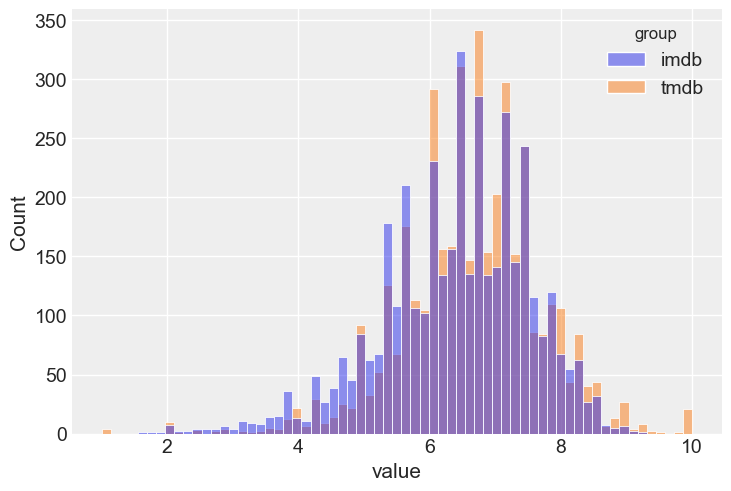

In [13]:
# Check the distribution of the two scores, from imdb and from tmbdb
y  = pd.DataFrame(dict(value=np.r_[netflix['imdb_score'], netflix['tmdb_score']], 
                       group=np.r_[['imdb']*len(netflix['imdb_score']), ['tmdb']*len(netflix['tmdb_score'])]))

sns.histplot(data=y, x="value", hue="group");

In [14]:
# Check the distribution of the two scores, from imdb and from tmbdb
# y  = pd.DataFrame(dict(value=np.r_[drama['imdb_score'], comedy['imdb_score']], 
#                        group=np.r_[['drama']*len(drama['imdb_score']), ['comedy']*len(comedy['imdb_score'])]))

# sns.histplot(data=y, x="value", hue="group");

### Research questions

Possible question 1: is the hypothesis of equal means of the two populations(imdb scores and tmdb scores) plausible?

Possible question 2: which is the probability of the two database to have the same score?

* We will fit a normal-normal model on each group.


* Then we will study the posterior distribution of the difference ($\mu_1 - \mu_2$)


* Recall the normal-normal model:
\begin{align*}
\mu & \sim N(\mu', \sigma_{\mu}) \\
\sigma &  \sim \text{half-normal}(\xi) \\
y & \sim N(\mu, \sigma) \\
\end{align*}

In [15]:
# Compute the mean score and standard deviation for imdb and tmdb
netflix_describe = netflix.describe()

# Mean scores
imdb_mean = netflix_describe['imdb_score'].loc['mean']
tmdb_mean = netflix_describe['tmdb_score'].loc['mean']
print("imdb mean score:", imdb_mean)
print("tmdb mean score:", tmdb_mean)
scores_mean = (imdb_mean + tmdb_mean)/2
print('mean score:', scores_mean)

# Standard deviations
imdb_std = netflix_describe['imdb_score'].loc['std']
tmdb_std = netflix_describe['tmdb_score'].loc['std']
print("\nimdb std:", imdb_std)
print("tmdb std:", tmdb_std)
std_mean = (imdb_std + tmdb_std)/2
print('mean std:', std_mean)

imdb mean score: 6.389899485167937
tmdb mean score: 6.622134346653581
mean score: 6.5060169159107595

imdb std: 1.1332380635930401
tmdb std: 1.0673718042503184
mean std: 1.1003049339216793


### Background information to set the prior

* The mean of the scores is about 6.5.
* The score of movies and tv shows follow a normal distribution, its mean can be assumed to be in (4.5, 8.5).
* Extreme values for the score are 1 (very poorly-made film) and 10 (masterpiece film). A plausible value for the standard deviation in the population is thus (6.5-1)/2 = 2.75.

### Prior for $\mu_{\text{imdb}}$ and $\mu_{\text{tmdb}}$

* The mean score of the population lies in (4.5, 8.5);  we interpret this as an interval of $\pm 2 \sigma$ around the mean. Thus:

$$
\mu_{\text{imdb}}   \sim  N (6.5, 1.375)
$$
$$
\mu_{\text{tmdb}}   \sim  N (6.5, 1.375)
$$

* We assign the same priors to both groups, so that we are not favoring a group over another a priori.

Ideally we tune the half-normal prior for sigma, adjusting the scale to have the median close to 2.75. In our case we don't want values over 10 since it is the maximun score so we tuned the scale to have a maximun value of about 10.

In [16]:
# this yields a  diffuse prior, but still defined over plausible range. 
pd.DataFrame(halfnorm.rvs(scale=2.7, size=10000)).describe()

,0
count,10000.000000
mean,2.168095
std,1.633094
min,0.000448
25%,0.882789
50%,1.836124
75%,3.106749
max,10.330372


### Likelihood


* Assuming a Gaussian distribution of the observations,  we have:

$$\vec{y}_{imdb} \sim N(\mu_{\text{imdb}}, \sigma_{\text{imdb}})$$

$$\vec{y}_{tmdb} \sim N(\mu_{\text{tmdb}}, \sigma_{\text{tmdb}})$$

where we use the vector notation to make it clear that these are array of measures.

###  The probabilistic model

* We assume the two population to have different $\sigma$ (often  the same $\sigma$ is assumed for both populations).

\begin{align*}
\mu_{\text{imdb}} & \sim N(6.5,1.133) \\
\sigma_{\text{imdb}} & \sim \text{half-normal} (2.75) \\
\vec{y}_{\text{imdb}}  & \sim N(\mu_{\text{imdb}}, \sigma_{\text{imdb}}) \\
\\
\mu_{\text{tmdb}} & \sim N(6.5,1.067) \\
\sigma_{\text{tmdb}} & \sim \text{half-normal} (2.75) \\
\vec{y}_{\text{tmdb}}  & \sim N(\mu_{\text{tmdb}}, \sigma_{\text{tmdb}})\\
\end{align*}


### Comparing two means $\mu_1$ and $\mu_2$

We consider  the difference between the means of the populations:
$$\mu_1 - \mu_2$$ 

* We  can define it as a *deterministic* variables in PyMC3, as it is a deterministic function of two parameters.


* We will have the posterior samples of ($\mu_1 - \mu_2$) in the trace.

In [17]:
# with pm.Model() as normal_model:
#     #prior
#     mu_imdb = pm.Normal('mu_imdb', mu = 6.5, sd = 1.133)
#     mu_tmdb = pm.Normal('mu_tmdb', mu = 6.5, sd = 1.067)
#     sigma_imdb = pm.HalfNormal('sigma_imdb', sigma=2.7)
#     sigma_tmdb = pm.HalfNormal('sigma_tmdb', sigma=2.7)

    
#     #likelihood of group 1
#     #y_imdb = pm.Normal('y_1', mu=mu_imdb, sigma=sigma_imdb, observed=netflix_describe['imdb_score'])
#     y_imdb = pm.Bound(pm.Normal, lower=1, upper=10)('y_1', mu=mu_imdb, sd=sigma_imdb, observed=netflix_describe['imdb_score'])
    
#     #likelihood of group 2
#     #y_tmdb = pm.Normal('y_2', mu=mu_tmdb, sigma=sigma_tmdb, observed=netflix_describe['tmdb_score'])
#     y_tmdb = pm.Bound(pm.Normal, lower=1, upper=10)('y_2', mu=mu_tmdb, sd=sigma_tmdb, observed=netflix_describe['tmdb_score'])
    
#     #The deterministic variables are function of the parameters, whose values appear in the trace.
#     diff_of_means = pm.Deterministic ('diff_of_means', mu_imdb - mu_tmdb)

In [18]:
with pm.Model() as score_model_1:
    #prior
    mu_imdb = pm.Normal('mu_imdb', mu=6.5, sd=1.5)
    mu_tmdb = pm.Normal('mu_tmdb', mu=6.5, sd=1.5)
    sigma_imdb = pm.HalfNormal('sigma_imdb', sigma=2.75)
    sigma_tmdb = pm.HalfNormal('sigma_tmdb', sigma=2.75)
    
    #likelihood of group 1
    y_imdb = pm.Normal('y_1', mu=mu_imdb, sigma=sigma_imdb, observed= netflix['imdb_score'])
    
    #likelihood of group 2
    y_tmdb = pm.Normal('y_2', mu=mu_tmdb, sigma=sigma_tmdb, observed= netflix['tmdb_score'])
    
    #The deterministic variables are function of the parameters, whose values appear in the trace.
    diff_of_means = pm.Deterministic ('diff_of_means', mu_imdb - mu_tmdb)

In [19]:
with score_model_1:
    score_model_1_trace = pm.sample(return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_tmdb, sigma_imdb, mu_tmdb, mu_imdb]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 20 seconds.


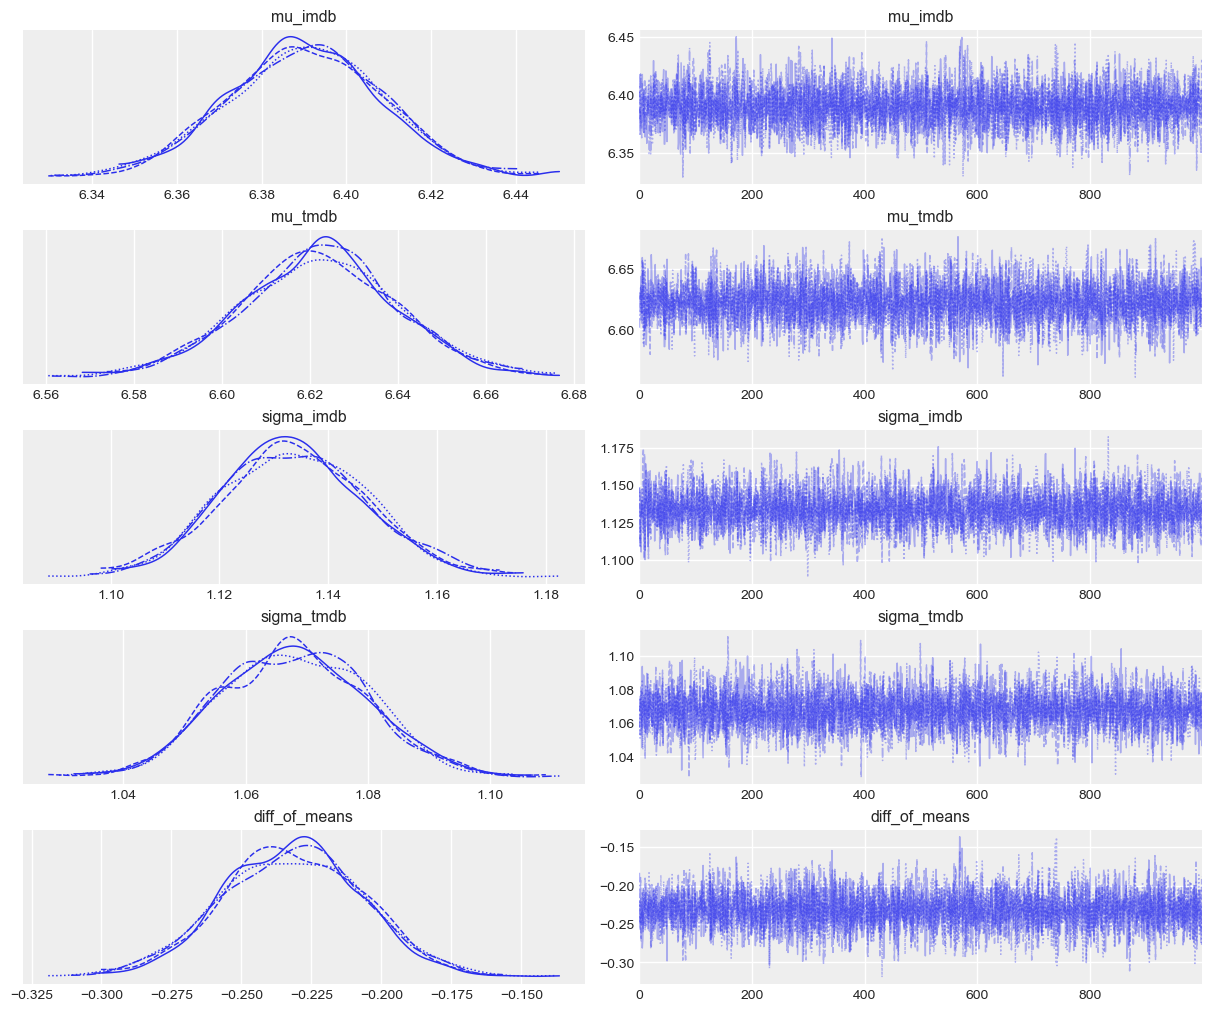

In [20]:
#sampling was good. The posterior of sigma is very similar for both groups, while there are differences in  the posterior mean of the two groups.
az.plot_trace(score_model_1_trace);

In [21]:
with pm.Model() as score_model_2:
    #prior
    mu_imdb = pm.Normal('mu_imdb', mu=imdb_mean, sd=imdb_std)
    mu_tmdb = pm.Normal('mu_tmdb', mu=tmdb_mean, sd=tmdb_std)
    sigma_imdb = pm.HalfNormal('sigma_imdb', sigma=2.75)
    sigma_tmdb = pm.HalfNormal('sigma_tmdb', sigma=2.75)
    
    #likelihood of group 1
    y_imdb = pm.Normal('y_1', mu=mu_imdb, sigma=sigma_imdb, observed= netflix['imdb_score'])
    
    #likelihood of group 2
    y_tmdb = pm.Normal('y_2', mu=mu_tmdb, sigma=sigma_tmdb, observed= netflix['tmdb_score'])
    
    #The deterministic variables are function of the parameters, whose values appear in the trace.
    diff_of_means = pm.Deterministic ('diff_of_means', mu_imdb - mu_tmdb)

In [22]:
with score_model_2:
    score_model_2_trace = pm.sample(return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_tmdb, sigma_imdb, mu_tmdb, mu_imdb]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 20 seconds.


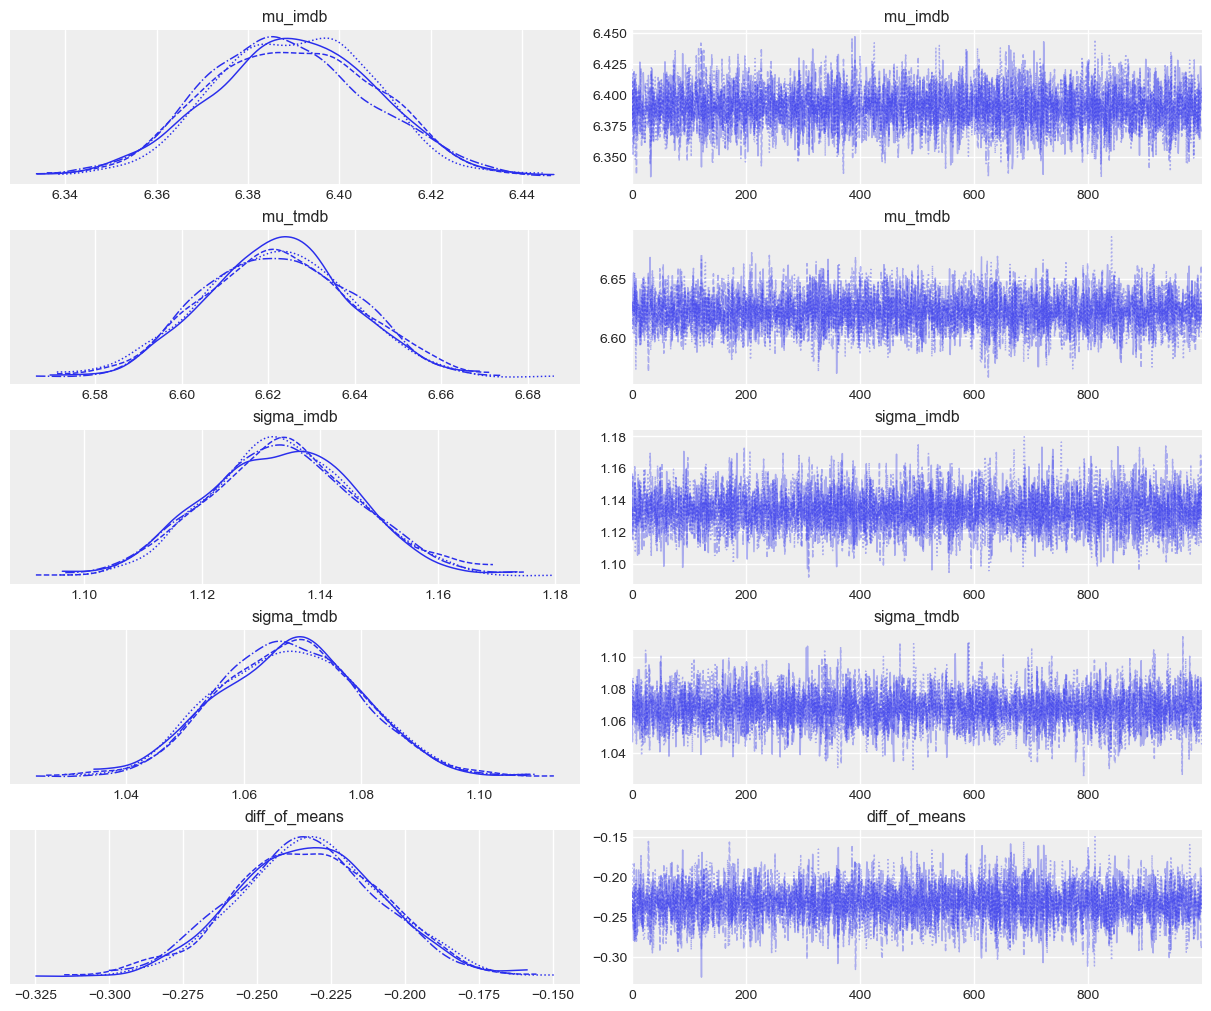

In [23]:
#sampling was good. The posterior of sigma is very similar for both groups, while there are differences in  the posterior mean of the two groups.
az.plot_trace(score_model_2_trace);

To test the prior sensitivity...

In [24]:
# Prior sensitivity

Possible question 1: is the hypothesis of equal means of the two populations plausible?
In traditional hypothesis testing, this corresponds to test the  hypothesis diff mu = 0.
Formally the 0 is a plausible value (although at the very limit of the 95% HDI) 

In [25]:
az.summary(score_model_1_trace, hdi_prob=0.95)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_imdb,6.390,0.018,6.354,6.424,0.0,0.0,6329.0,3082.0,1.0
mu_tmdb,6.622,0.018,6.586,6.656,0.0,0.0,6740.0,3297.0,1.0
sigma_imdb,1.134,0.013,1.109,1.160,0.0,0.0,7211.0,2917.0,1.0
sigma_tmdb,1.068,0.012,1.046,1.091,0.0,0.0,6853.0,3108.0,1.0
diff_of_means,-0.232,0.025,-0.282,-0.184,0.0,0.0,6975.0,3107.0,1.0


In [26]:
az.summary(score_model_2_trace, hdi_prob=0.95)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_imdb,6.390,0.018,6.356,6.424,0.0,0.0,6528.0,3214.0,1.0
mu_tmdb,6.622,0.017,6.591,6.655,0.0,0.0,6250.0,3383.0,1.0
sigma_imdb,1.134,0.013,1.110,1.160,0.0,0.0,7161.0,3260.0,1.0
sigma_tmdb,1.068,0.012,1.044,1.090,0.0,0.0,5714.0,3320.0,1.0
diff_of_means,-0.233,0.025,-0.282,-0.187,0.0,0.0,6182.0,2923.0,1.0


Here our difference of means is 0.232, so we can say that the two means are practically equal.

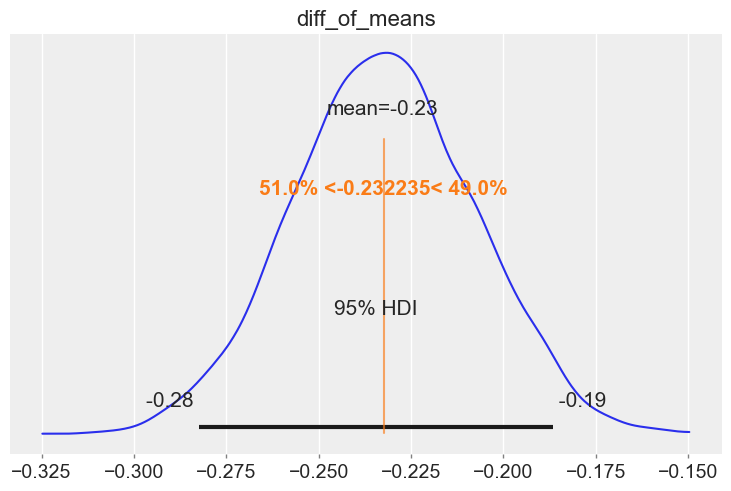

In [27]:
# Possible question 2: which is the posterior probability of an higher score in imdb scoreboard?
r_val = imdb_mean - tmdb_mean
#There is a probability >95% of tmdb giving an higher score than imdb; thus we accept the hypothesis oftmdb giving higher scores.
az.plot_posterior(score_model_2_trace,  var_names="diff_of_means", ref_val=r_val, hdi_prob=0.95);

We used as reference value the actual difference between the two populations means and we see it fall almost exactly in the middle of the posterior distribution. We can't say that imdb has generally higher scores than tmdb or viceversa.

# Balance data

In [69]:
# n = 10
# c = netflix.groupby(['director']).count()
# c = c.sort_values('title', ascending=False)
# d_mask = c.iloc[:n].reset_index()
# directors = netflix[netflix["director"].isin(d_mask["director"])].reset_index(drop=True)
# directors

,title,type,release_year,age_certification,runtime,genres,production_countries,seasons,imdb_score,imdb_votes,tmdb_popularity,tmdb_score,director,director_code,is_action
0,Cairo Station,MOVIE,1958,NaN,77,"['drama', 'crime', 'comedy']",['EG'],NaN,7.5,4471.0,5.546,7.3,Youssef Chahine,3060,False
1,Alexandria… Why?,MOVIE,1979,NaN,133,['drama'],['EG'],NaN,7.2,1727.0,1.370,6.0,Youssef Chahine,3060,False
2,The Land,MOVIE,1969,NaN,129,['drama'],['EG'],NaN,8.1,1958.0,1.265,8.5,Youssef Chahine,3060,False
3,Saladin the Victorious,MOVIE,1963,NaN,186,"['action', 'drama', 'war', 'history', 'romance']",['EG'],NaN,7.6,2508.0,4.156,7.1,Youssef Chahine,3060,True
4,The Blazing Sun,MOVIE,1954,NaN,100,"['crime', 'romance', 'drama']",['EG'],NaN,7.4,1219.0,2.184,7.0,Youssef Chahine,3060,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130,Snoop Dogg's F*cn Around Comedy Special,MOVIE,2022,NaN,67,"['documentation', 'comedy', 'music']",[],NaN,5.2,371.0,5.006,5.3,Ryan Polito,2489,False
131,Jeff Foxworthy: The Good Old Days,MOVIE,2022,NaN,60,"['comedy', 'documentation']",[],NaN,6.1,418.0,2.434,6.8,Ryan Polito,2489,False
132,Christina P: Mom Genes,MOVIE,2022,NaN,62,"['comedy', 'documentation']",[],NaN,5.8,605.0,2.244,6.8,Ryan Polito,2489,False
133,Carlos Ballarta: False Prophet,MOVIE,2021,NaN,63,['comedy'],['MX'],NaN,6.7,132.0,3.738,5.2,Raúl Campos,2340,False


In [93]:
netflix["before_2010"] = netflix["release_year"] <= 2010

In [95]:
netflix["before_2010"].value_counts()

False    3592
True      487
Name: before_2010, dtype: int64

In [91]:
df0 = netflix[netflix["type"] != 'SHOW']
df1 = df0[df0["before_2010"] == False]

df2 = df0[df0["before_2010"] == True]

df1 = df1.sample(n=500, random_state=42)
df1

,title,type,release_year,age_certification,runtime,genres,production_countries,seasons,imdb_score,imdb_votes,tmdb_popularity,tmdb_score,director,director_code,is_action,before_2000
0,Taxi Driver,MOVIE,1976,R,114,"['drama', 'crime']",['US'],NaN,8.2,808582.0,40.965,8.179,Martin Scorsese,1810,False,True
1,Deliverance,MOVIE,1972,R,109,"['drama', 'action', 'thriller', 'european']",['US'],NaN,7.7,107673.0,10.010,7.300,John Boorman,1276,True,True
2,Monty Python and the Holy Grail,MOVIE,1975,PG,91,"['fantasy', 'action', 'comedy']",['GB'],NaN,8.2,534486.0,15.461,7.811,Terry Jones,2815,True,True
3,Monty Python and the Holy Grail,MOVIE,1975,PG,91,"['fantasy', 'action', 'comedy']",['GB'],NaN,8.2,534486.0,15.461,7.811,Terry Gilliam,2813,True,True
4,The Dirty Dozen,MOVIE,1967,NaN,150,"['war', 'action']","['GB', 'US']",NaN,7.7,72662.0,20.398,7.600,Robert Aldrich,2413,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4540,I Missed You,MOVIE,2021,NaN,96,"['drama', 'romance']",['TW'],NaN,5.7,250.0,2.451,6.300,Chih-yen Hsu,474,False,False
4541,My Amanda,MOVIE,2021,NaN,89,"['drama', 'romance']",['PH'],NaN,5.7,308.0,2.908,5.700,Alessandra de Rossi,102,False,False
4543,Happiness Ever After,MOVIE,2021,NaN,99,"['drama', 'romance']",['ZA'],NaN,4.2,163.0,11.536,7.300,Thabang Moleya,2819,False,False
4547,My Bride,MOVIE,2021,NaN,93,"['romance', 'comedy', 'drama']",['EG'],NaN,5.0,327.0,2.545,5.300,Mohamed Bakir,1961,False,False


In [99]:
df = pd.concat([df1, df2], ignore_index=True)
df["before_2010"].value_counts()

False    500
True     487
Name: before_2010, dtype: int64

Yılmaz Erdoğan
Abhishek Chaubey
Youssef Chahine
Wilson Yip	
sample_directors = ('Yılmaz Erdoğan', 'Abhishek Chaubey', 'Youssef Chahine', 'Wilson Yip')


In [71]:
# netflix["is_action"].value_counts()

False    3275
True      804
Name: is_action, dtype: int64

# Pooled Bayesian Model

Consider the following *pooled* Bayesian model:
\begin{align*}
\mu &\sim N(6.5, 0.5) \\
\sigma &\sim \text{HalfNormal}(1.4) \\
\vec{y}_{ij} &\sim N(\mu, \sigma) \\
\end{align*}


The model does not make distinction between different directors. It is a single normal-normal model for measurements from all the different directors; it assumes the measurement to share *global* mean and standard deviation $\mu$ and $\sigma$, respectively. 

We assume that: 
1. The (global) mean film score $\mu$ is between $6.5-3*0.5=5$ and $6.5+3*0.5=8$ with probability 99%
2. All scores $\vec{y}_{ij}$ are in a range of width $0.95*10=9.5$ with probability 99%


In [30]:
pd.DataFrame(stats.halfnorm.rvs(size=10_000, scale=1.4)).median()

0    0.929773
dtype: float64

In [31]:
with pm.Model() as model_pooled:
    global_mu = pm.Normal('global_mu', mu=6.5, sd=0.5)
    global_sigma = pm.HalfNormal('global_sigma', sd=1.4)
    y = pm.Normal('y', mu=global_mu, sd=global_sigma, observed=directors["imdb_score"])
    trace_pooled = pm.sample(10_000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [global_sigma, global_mu]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 31 seconds.


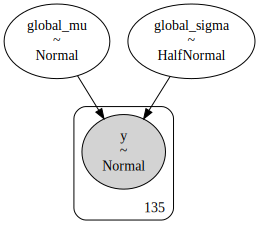

In [32]:
pm.model_to_graphviz(model_pooled)

In [33]:
with model_pooled:
    display(az.summary(trace_pooled))

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
global_mu,6.450,0.084,6.296,6.609,0.0,0.0,35135.0,28292.0,1.0
global_sigma,0.989,0.062,0.878,1.108,0.0,0.0,34533.0,27267.0,1.0


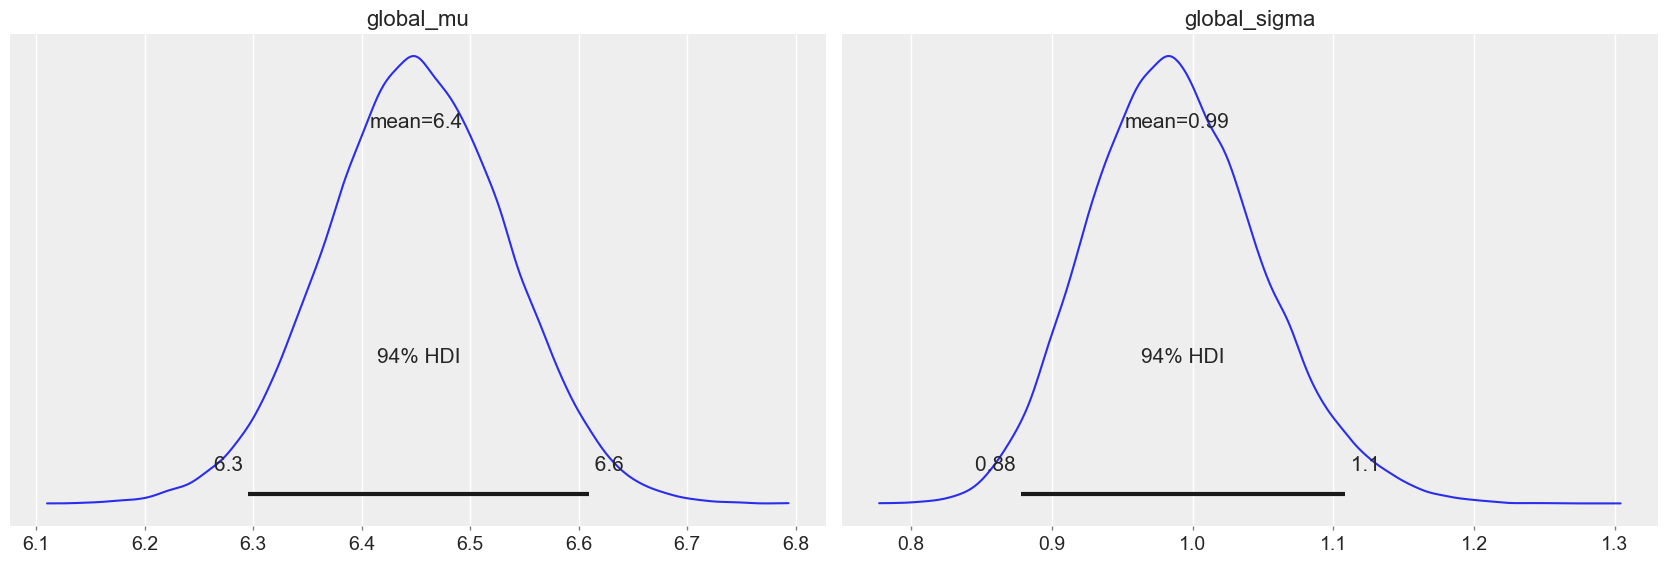

In [34]:
with model_pooled:
    az.plot_posterior(trace_pooled);

# Pooled regression

A regression model which ignores the director:

$$Y \sim N( \alpha + \beta X, \sigma)$$


* $Y$: imdb score (919 measures)

* $X$: film (1 or 0)

* $\alpha$ : intercept.  (on  centered data, it represents the mean log-radon in Minnesota). 


* We use the centered covariate  $X_c = X - \bar{x}$


* We have no prior knowledge and thus we use fall back to  weakly informative, data-dependent, priors:

\begin{align}
Y  &\sim N( \alpha_c + \beta X_c,  \sigma) && \text{likelihood}\\
\alpha &\sim N(\bar{y},2 s_y) && \text{prior on the intercept} \\
\beta  & \sim N (0,2.5 \frac{s_y}{s_x})  && \text{prior on the slope} \\
\sigma &\sim \text{HalfNormal}(0,1.5 s_y )&& \text{prior on the dev std } \\
\end{align}

In [ ]:
#list of  counties in Minnesota (85 different counties)
directors_names = netflix.director.unique()
n_directors = counties.shape[0] 

#numerical id of the county of each measure (919 rows)
direc = netflix["director"].astype("category")
directors_code = direc.cat.codes
# county = radon_data.county_code.values
#code and name of each county
county_lookup = dict(zip(counties, np.arange(n_counties)))

#explanatory variable: the floor: 0 (ground level) or 1 (first floor).
floor           = radon_data.floor.values

#y 
log_radon         = radon_data.log_radon.values

In [6]:
#implementation of the pooled model

#centering is needed to have effective sampling
floor_c  = (floor - floor.mean())
mu_y    = log_radon.mean()
s_y        = log_radon.std()
s_x        = floor_c.std()

with pm.Model() as pooled_model:

    alpha  = pm.Normal('alpha', mu= mu_y,  sigma= 2 * s_y)
    beta    = pm.Normal('beta', mu=0,  sigma= 2.5 * s_y/s_x)
    sigma = pm.HalfNormal('sigma', 1.5 * s_y)
    y          = pm.Normal('y', alpha + beta * floor_c, sigma, observed=log_radon)
    

In [ ]:
sample_directors = ('Yılmaz Erdoğan', 'Abhishek Chaubey', 'Youssef Chahine', 'Wilson Yip')

# Unpooled Bayesian Model

Consider the following Bayesian unpooled model
\begin{align*}
\mu_{j} &\sim {N}(6.5, 1) \\
\sigma_{j} &\sim \text{HalfNormal}(0.6) \\
\vec{y}_{ij} &\sim {N}(\mu_j, \sigma_j) \\
\end{align*}

The unpooled model actually consists in N completely separate normal-normal sub-models for each director. 

1. The mean imdb film score of each director is between $6.5-3*1=3.5$ and $6.5+3*1=9.5$ with probability 99%
2. The imdb score measurements of each director are in a range of width $0.4*10=4$ with probability 99%

In [35]:
pd.DataFrame(stats.halfnorm.rvs(size=10_000, scale=0.6)).median()

0    0.413046
dtype: float64

In [36]:
directors = directors.sort_values('director').reset_index(drop=True)
directors

,title,type,release_year,age_certification,runtime,genres,production_countries,seasons,imdb_score,imdb_votes,tmdb_popularity,tmdb_score,director
0,Three Words to Forever,MOVIE,2018,NaN,106,"['drama', 'family', 'comedy', 'romance']",['XX'],NaN,6.8,110.0,2.040,10.0,Cathy Garcia-Molina
1,It Takes a Man and a Woman,MOVIE,2013,NaN,120,"['romance', 'comedy', 'drama']",['PH'],NaN,6.7,363.0,1.892,7.8,Cathy Garcia-Molina
2,She's Dating the Gangster,MOVIE,2014,NaN,105,"['drama', 'romance', 'comedy']",['PH'],NaN,7.0,1100.0,3.134,7.2,Cathy Garcia-Molina
3,A Very Special Love,MOVIE,2008,PG,105,"['comedy', 'drama', 'romance']",['PH'],NaN,6.5,391.0,2.281,7.3,Cathy Garcia-Molina
4,My Amnesia Girl,MOVIE,2010,NaN,110,"['comedy', 'romance']",['PH'],NaN,6.7,432.0,2.228,6.4,Cathy Garcia-Molina
...,...,...,...,...,...,...,...,...,...,...,...,...,...
130,An Egyptian Story,MOVIE,1982,NaN,129,"['drama', 'fantasy']",['EG'],NaN,7.3,1126.0,1.770,6.7,Youssef Chahine
131,The Other,MOVIE,1999,NaN,106,"['romance', 'european', 'drama']","['FR', 'EG']",NaN,5.9,997.0,1.120,5.9,Youssef Chahine
132,The Emigrant,MOVIE,1994,NaN,129,['drama'],"['FR', 'EG']",NaN,6.5,1015.0,1.400,6.0,Youssef Chahine
133,Alexandria… Why?,MOVIE,1979,NaN,133,['drama'],['EG'],NaN,7.2,1727.0,1.370,6.0,Youssef Chahine


In [37]:
directors["director"] = directors["director"].astype("category")
directors["director_id"] = directors["director"].cat.codes
list_directors = list(directors["director"].cat.categories)
n_directors = len(list_directors) # number of directors (10)
list_directors, n_directors

(['Cathy Garcia-Molina',
  'Jan Suter',
  'Jay Chapman',
  'Jay Karas',
  'Justin G. Dyck',
  'Marcus Raboy',
  'Raúl Campos',
  'Ryan Polito',
  'Troy Miller',
  'Youssef Chahine'],
 10)

In [38]:
# directors["director_id"] = directors.groupby('director').ngroup()
# directors

In [39]:
with pm.Model() as model_unpooled:
    group_mu = pm.Normal('group_mu', mu=6.5, sd=1, shape=n_directors)
    group_sigma = pm.HalfNormal('group_sigma', sd=1, shape=n_directors)
    
    y = pm.Normal('y', mu=group_mu[directors["director_id"]], sd=group_sigma[directors["director_id"]], observed=directors["imdb_score"])
    
    trace_unpooled = pm.sample(10_000, return_inferencedata=True)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [group_sigma, group_mu]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 35 seconds.


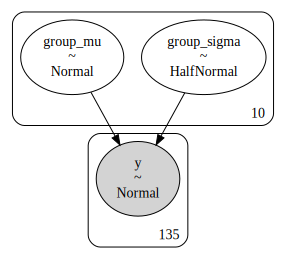

In [40]:
pm.model_to_graphviz(model_unpooled)

In [41]:
trace_unpooled.posterior = trace_unpooled.posterior.assign_coords(group_mu_dim_0=list_directors,
                                                                  group_sigma_dim_0=list_directors)

In [42]:
with model_unpooled:
    display(az.summary(trace_unpooled))

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
group_mu[Cathy Garcia-Molina],6.963,0.206,6.572,7.355,0.001,0.001,55150.0,28357.0,1.0
group_mu[Jan Suter],6.076,0.201,5.699,6.460,0.001,0.001,64258.0,28597.0,1.0
group_mu[Jay Chapman],6.690,0.214,6.282,7.093,0.001,0.001,54291.0,28814.0,1.0
group_mu[Jay Karas],6.850,0.250,6.366,7.309,0.001,0.001,60436.0,28658.0,1.0
group_mu[Justin G. Dyck],5.088,0.265,4.611,5.617,0.001,0.001,50366.0,26793.0,1.0
group_mu[Marcus Raboy],6.625,0.162,6.314,6.929,0.001,0.000,63224.0,29704.0,1.0
group_mu[Raúl Campos],6.106,0.197,5.734,6.478,0.001,0.001,66452.0,29423.0,1.0
group_mu[Ryan Polito],6.469,0.330,5.853,7.103,0.001,0.001,71643.0,30356.0,1.0
group_mu[Troy Miller],6.568,0.284,6.007,7.090,0.001,0.001,54355.0,28234.0,1.0
group_mu[Youssef Chahine],7.057,0.208,6.663,7.451,0.001,0.001,50786.0,28725.0,1.0


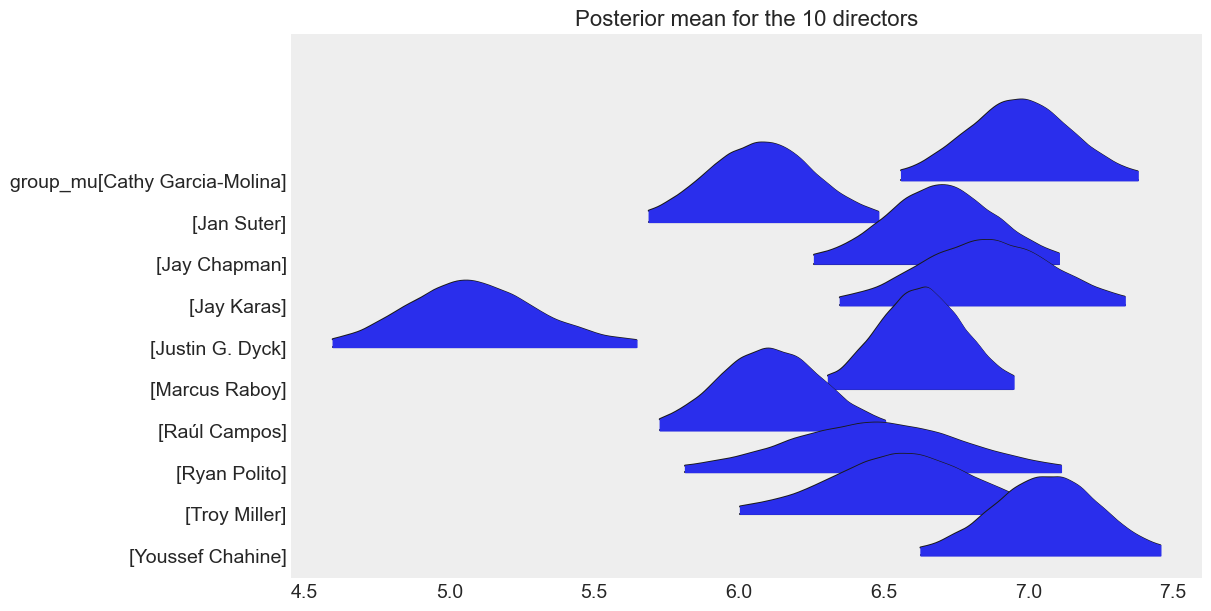

In [43]:
with model_unpooled:
    axes = az.plot_forest (trace_unpooled,  kind='ridgeplot', hdi_prob=0.95, var_names="group_mu", combined=True);
    plt.title("Posterior mean for the 10 directors")
    #axes[0].set_yticklabels(machines[::-1])
    

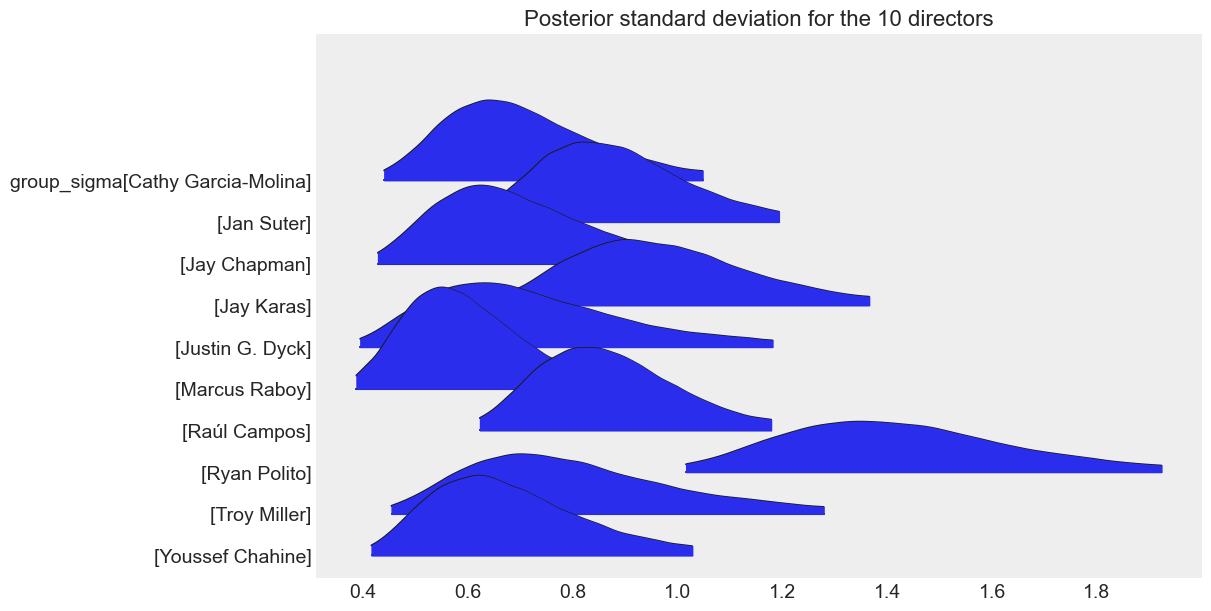

In [44]:
with model_unpooled:
    axes = az.plot_forest (trace_unpooled,  kind='ridgeplot', hdi_prob=0.95, var_names="group_sigma", combined=True);
    plt.title("Posterior standard deviation for the 10 directors")
    #axes[0].set_yticklabels(machines[::-1])

In [45]:
with model_unpooled:
    display(az.summary(trace_unpooled, var_names=["group_sigma"]))

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
group_sigma[Cathy Garcia-Molina],0.715,0.166,0.436,1.017,0.001,0.001,59724.0,30247.0,1.0
group_sigma[Jan Suter],0.887,0.153,0.625,1.174,0.001,0.000,67397.0,30378.0,1.0
group_sigma[Jay Chapman],0.706,0.173,0.432,1.028,0.001,0.001,57080.0,28993.0,1.0
group_sigma[Jay Karas],0.987,0.192,0.648,1.337,0.001,0.001,68385.0,28872.0,1.0
group_sigma[Justin G. Dyck],0.738,0.222,0.390,1.142,0.001,0.001,53921.0,29515.0,1.0
group_sigma[Marcus Raboy],0.603,0.129,0.388,0.840,0.001,0.000,63390.0,29947.0,1.0
group_sigma[Raúl Campos],0.877,0.147,0.626,1.159,0.001,0.000,66408.0,30816.0,1.0
group_sigma[Ryan Polito],1.435,0.239,1.012,1.882,0.001,0.001,65096.0,29169.0,1.0
group_sigma[Troy Miller],0.818,0.230,0.454,1.245,0.001,0.001,55577.0,30697.0,1.0
group_sigma[Youssef Chahine],0.689,0.169,0.420,1.006,0.001,0.001,60020.0,30539.0,1.0


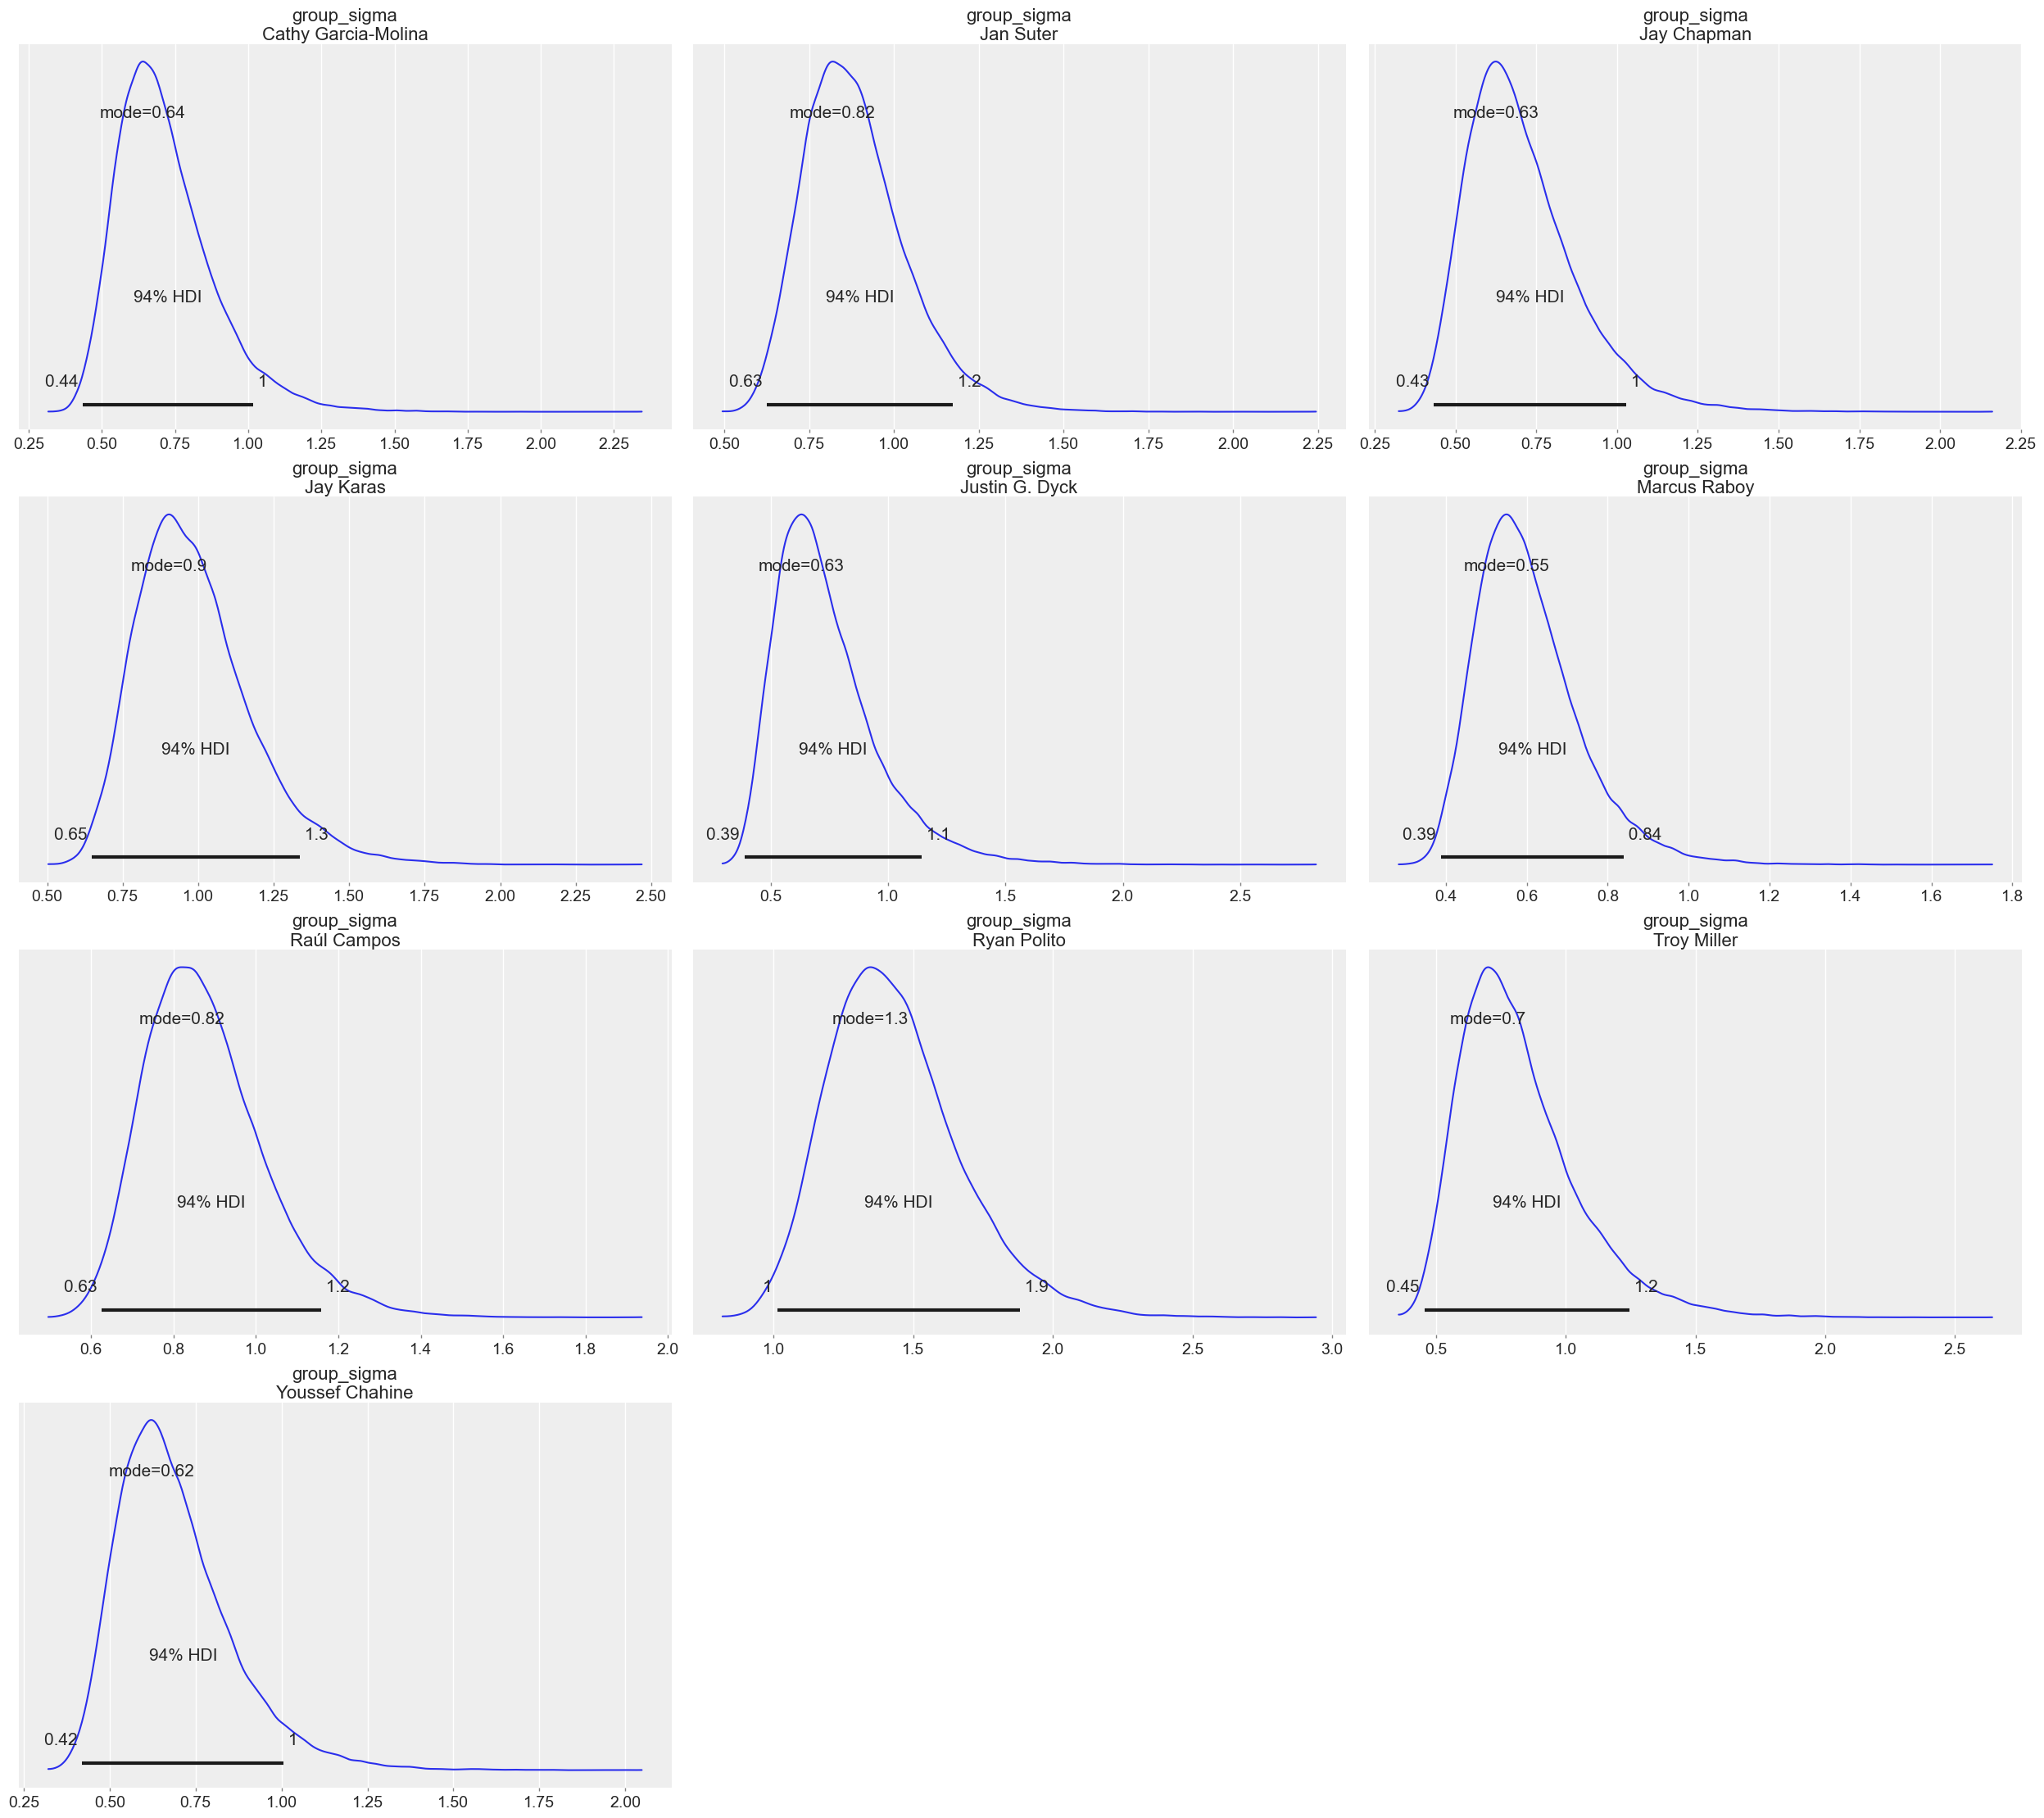

In [46]:
# az.plot_posterior(trace_separate["group_std"][:, 0], point_estimate='mode')
with model_unpooled:
    az.plot_posterior(trace_unpooled, var_names=["group_sigma"], point_estimate='mode'); # the posterior mean is 29, the mode is 19!

# Hierarchical model

In [47]:
directors.describe()

,release_year,runtime,seasons,imdb_score,imdb_votes,tmdb_popularity,tmdb_score,director_id
count,135.000000,135.000000,4.0,135.000000,135.000000,135.000000,135.000000,135.000000
mean,2013.762963,74.348148,1.0,6.448889,1279.407407,2.981859,6.446415,4.370370
std,12.722766,24.835674,0.0,0.981384,1644.718242,2.258949,0.977734,2.803891
min,1954.000000,25.000000,1.0,3.800000,40.000000,0.724000,3.800000,0.000000
25%,2016.000000,60.000000,1.0,5.700000,213.000000,1.400000,5.850000,2.000000
50%,2017.000000,67.000000,1.0,6.600000,652.000000,2.463000,6.500000,5.000000
75%,2018.000000,80.000000,1.0,7.200000,1641.500000,3.616500,7.100000,7.000000
max,2022.000000,186.000000,1.0,8.600000,8084.000000,15.911000,10.000000,9.000000


## Hierarchical model, common std

Consider the following Bayesian hierarchical model:

\begin{align*}
\mu_\mu & \sim N(6.5, 0.5)\\
\sigma_\mu  & \sim \text{HalfNormal}(0.9) \\
\mu_{j} &\sim {N}(\mu_\mu, \sigma_\mu) \\
\sigma &\sim \text{HalfNormal}(0.4) \\
\vec{y}_{ij} &\sim {N}(\mu_j, \sigma) \\
\end{align*}



From the numerical values of the model coefficients, the modeler might have made the following assumptions:
1. The mean of the mean film score from each director is between $6.5-3*0.5=5$ and $6.5+3*0.5=8$ with probability 99% $\Rightarrow$ from $\mu_\mu \sim N(6.5, 0.5)$
2. The score measurements from each director are in a range of width $0.4*10=4$ with probability 99% $\Rightarrow$ from $\sigma \sim \text{HalfNormal}(0.6)$
3. The different $\mu_j$ vary in a range of width $10*0.6=6$ with probability 99% $\Rightarrow$ from $\sigma_\mu  \sim \text{HalfNormal}(0.9)$

In [48]:
pd.DataFrame(stats.halfnorm.rvs(size=10_000, scale=0.6)).median()

0    0.406208
dtype: float64

In [49]:
pd.DataFrame(stats.halfnorm.rvs(size=10_000, scale=0.9)).median()

0    0.612499
dtype: float64

In [50]:
with pm.Model() as model_hierarchical:
    
    # hyper_priors
    mu_mu = pm.Normal('mu_mu', mu=6.5, sd=0.5)
    sigma_mu = pm.HalfNormal('sigma_mu', sd=0.9)

    # priors    
    group_mu = pm.Normal('group_mu', mu=mu_mu, sd=sigma_mu, shape=n_directors)
    global_std = pm.HalfNormal('global_std', sd=0.4)
    y = pm.Normal('y', mu=group_mu[directors["director_id"]], sd=global_std, observed=directors["imdb_score"])
    trace_hierarchical = pm.sample(10_000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [global_std, group_mu, sigma_mu, mu_mu]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 36 seconds.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.


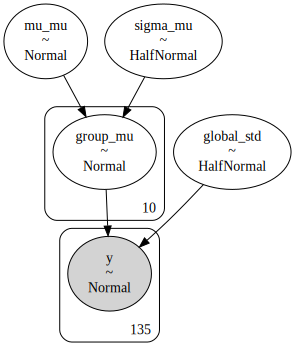

In [51]:
pm.model_to_graphviz(model_hierarchical)

In [52]:
trace_hierarchical.posterior = trace_hierarchical.posterior.assign_coords(group_mu_dim_0=list_directors)

In [53]:
az.summary(trace_hierarchical)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_mu,6.457,0.188,6.102,6.818,0.001,0.001,50711.0,31118.0,1.0
group_mu[Cathy Garcia-Molina],6.885,0.231,6.466,7.334,0.001,0.001,55773.0,28392.0,1.0
group_mu[Jan Suter],6.109,0.189,5.760,6.467,0.001,0.001,57623.0,28732.0,1.0
group_mu[Jay Chapman],6.651,0.237,6.205,7.099,0.001,0.001,59271.0,30604.0,1.0
group_mu[Jay Karas],6.807,0.210,6.415,7.202,0.001,0.001,53608.0,29466.0,1.0
group_mu[Justin G. Dyck],5.356,0.314,4.766,5.936,0.002,0.001,39348.0,23944.0,1.0
group_mu[Marcus Raboy],6.601,0.215,6.202,7.010,0.001,0.001,64178.0,30960.0,1.0
group_mu[Raúl Campos],6.133,0.183,5.781,6.473,0.001,0.001,60510.0,29774.0,1.0
group_mu[Ryan Polito],6.463,0.195,6.104,6.832,0.001,0.001,64475.0,31156.0,1.0
group_mu[Troy Miller],6.543,0.270,6.035,7.053,0.001,0.001,63066.0,29444.0,1.0


In [54]:
director_mean_score=netflix.groupby(['director']).mean().sort_values('imdb_score')
director_mean_score=director_mean_score['imdb_score']
director_mean_score.describe()

count    3111.000000
mean        6.363342
std         1.099127
min         1.600000
25%         5.700000
50%         6.500000
75%         7.150000
max         9.100000
Name: imdb_score, dtype: float64

In [55]:
# Number of the songs of each artists; it varies between 2 and 40.
director_count=netflix.groupby(['director']).count().sort_values('title')
director_count=director_count['title']
director_count

director
Krishna D.K.           1
Monique Gardenberg     1
Monty Tiwa             1
Mor Loushy             1
Morgan Pehme           1
                      ..
Marcus Raboy          14
Jay Karas             15
Ryan Polito           17
Jan Suter             19
Raúl Campos           20
Name: title, Length: 3111, dtype: int64

# Predictions

In [ ]:
# Make predictions
new_film_data = {'director': 'Director Name'}
new_film_df = pd.DataFrame(data=new_film_data, index=[0])

In [ ]:
with model:
    a_pred = pm.sample_posterior_predictive(trace, vars=[a])['a']
    director_idx = netflix['director'].unique().tolist().index(new_film_df['director'].iloc[0])
    rating_pred = a_pred[:, director_idx]
    print(rating_pred.mean())

In [ ]:
#prediction for a novel artist
post_hier                = az.extract_dataset(trace_hier.posterior)

#posterior parameters of the population
mu_population     = post_hier.mu_pop.values
sigma_population = post_hier.sigma_mu.values

mu_new_artist  = np.zeros(len(mu_population))

for i, current_mu in enumerate(mu_population):
        mu_new_artist[i] = np.random.normal (loc = mu_population[i], scale = sigma_population[i])

#now we have the distribution for the mean of the novel artist.
#we thus compute the distribution for its next song
global_sigma = post_hier.global_sigma.values
popularity_new_song_new_artist  = np.zeros(len(global_sigma))

for i, current_mu in enumerate(mu_population):
        popularity_new_song_new_artist[i] = np.random.normal (loc = mu_new_artist[i], scale = global_sigma[i])

#we obtain a  large predictive distribution, whose 95% hdi varies between 9.8 and 94.
#there is a major increase in the std wrt a known artist such as Beyonce.
pd.DataFrame(popularity_new_song_new_artist).describe(percentiles=[0.025, 0.975])        

In [ ]:
# predictive distribution for a measure taken in a new county.
# This is not possible with the unpooled model.
# Part 1 

post_hier    = az.extract_dataset(hier_trace.posterior)

# First, we create plausible value of intercepts by sampling from the population of intercepts 
mu_a = post_hier.mu_a.values
sigma_a = post_hier.sigma_a.values
alpha_new = np.zeros(len(mu_a))

#for i, current_mu in enumerate(mu_a):
 #   alpha_new[i] = np.random.normal (loc = mu_a[i], scale = sigma_a[i])

#vectorized implementation is more elegant, but equivalent to the loop above
alpha_new = np.random.normal (loc = mu_a, scale = sigma_a)

 #samples of the slope and of the sigma   
beta_hier =  post_hier.beta.values
sigma_y =  post_hier.sigma_y.values

In [ ]:
# predictive distribution for a measure taken in a new county.
# Part 2 
        
#predictive distribution for a new measure in the new county
y_new = np.zeros(len(alpha_new))

for i, current_mu in enumerate(alpha_new):
        y_new[i] = np.random.normal (loc = alpha_new[i] + beta_hier[i] *  floor_0 , scale = sigma_y[i])

pd.DataFrame(y_new).describe()

In [ ]:
# the hierarchical model is ranked first
az.waic (pooled_trace)
az.compare({'pooled':pooled_trace, 'unpooled': unpooled_trace,  'hierarchical':hier_trace}, ic='waic')

In [ ]:
# we can also compare the models via WAIC

# the Student model is ranked first
az.compare({'gaussian':gaussian_trace, 'student': st_trace}, ic='waic')

# Compute predictive distributions


*  Compare the predictive distribution  for a floor measurement  for "lac qui parle", according to the unpooled and to  the varying-intercept hierarchical model.


 * Compute the  predictive distribution for a novel county using the  varying-intercept hierarchical model.



* Hint: the centered value of floor 0 is 0.16648531 (check np.unique(floor_c))


    

In [ ]:
#get the trace samples
post_hier    = az.extract_dataset(hier_trace.posterior)

#samples of the slope
beta_hier =  post_hier.beta.values

#samples of the intercept for LAC 
alpha_lac_hier = post_hier.alpha.values[county_lookup['LAC QUI PARLE']] 

#samples of sd
sigma_y_hier =  post_hier.sigma_y.values

In [ ]:
#Part 2 - computing the predictive based on the samples from the trace
y_new_hier = np.zeros(len(beta_hier))

#this could be easily vectorized. I leave the for loop mainly for clarity
for i, current_mu in enumerate(beta_hier):
        #to have a more precise quantification, we could generate more than one values   with the i-th sample of parameters.
        # that is how pymc3 implements the predictive checks.
        y_new_hier[i] = np.random.normal (loc = alpha_lac_hier[i] + beta_hier[i] *  floor_0 , scale = sigma_y_hier[i])
        
#the predictive distribution of the unpooled is much larger median and more uncertaint (larger std)        
a=  pd.DataFrame(y_new_hier).describe()
a

# Posterior distribution  of a novel group

In [ ]:
with pm.Model() as model_pooled_with_pred:
    
    global_mu = pm.Normal('global_mu', mu=6.5, sd=0.5)
    global_sigma = pm.HalfNormal('global_sigma', sd=1.4)
    y = pm.Normal('y', mu=global_mu, sd=global_sigma, observed=directors["imdb_score"])
    
    y_pred = pm.Normal("y_pred", mu=global_mu, sigma=global_sigma)
    
    trace_pooled_with_pred = pm.sample(10_000, return_inferencedata=True)

In [ ]:
with model_pooled_with_pred:
    display(az.summary(trace_pooled_with_pred)) # var_names='y_pred'

In [ ]:
with model_pooled_with_pred:
    az.plot_posterior(trace_pooled_with_pred);

# Model selection 

What is the best model ultimately? In our case: Pooled, Unpooled, or Hierarchical?


To answer this question, we need a **model selection** strategy/metric.

* You know metrics for point regression models (mse, rmse, mae,...)
* You know metrics for point classification models (accuracy, prediciton, recall...)


### The WAIC Criterion 
To score full Bayesian models, we need a metric that evaluates a (sample-based approximation of a) *distribution*. 

* A popular metric to score a distribution is the log-pointwise-predictive-density ${\rm lpd}(y, \Theta)$:
$$ {\rm lpd}(y, \Theta) = \sum_i \log \frac{1}{S} \sum_s p(y_i | \Theta_s),$$
where $y$ are the observations and $\Theta$ is the sample-based approximation of the posterior ($\Theta_s$ is a single MCMC draw). It is the (approximate) logarithm of the expected likelihood (the higher, the better)!


* The ${\rm lpd}(y, \Theta)$ generally increases for increasing model complexity and it is thus prone to overfitting when used on the same data used for model building. It should be evaluated with fresh data in (cross)-validation.

* The WAIC criterion (the lower, the better) balances high ${\rm lpd}$ and low model complexity explicitly. It can be applied directly on the training data $y$!

\begin{align}
{\rm WAIC}(y, \Theta) &= -2(\rm{lpd} - p_{\rm waic}).\\
 p_{{\rm waic}} &= \sum_i {\rm var}_{\theta} \log p(y_i|\theta)
\end{align}

* The WAIC is equivalent up to a factor to the ${\rm elpd}$, the *expected* $\rm{lpd}$ on fresh data (the higher, the better):

$${\rm elpd}(y, \Theta) = \rm{lpd} - p_{\rm waic}.$$

Advantages of WAIC/elpd:

* Well-defined both for continuous and for categorical observations
* Applicable to Bayesian models returning point-wise estimates
* Applicable to the training data directly (built-in complexity penalty)
* Works well in practice

Note: WAIC stands for Widely Applicable Information Criterion!

### The WAIC Criterion in arviz

Arviz has a built-in function `az.waic` to compute the WAIC (actually, as of v0.12.1, arviz computes the ${\rm elpd}$, see <a href="https://python.arviz.org/en/v0.12.1/api/generated/arviz.waic.html?highlight=waic">documentation</a>):


In [ ]:
az.waic(trace_pooled)

In [ ]:
#with factory_pooled, factory_separate, factory_hierarchical:
comp_df = az.compare({"model_pooled": trace_pooled,
                      "model_unpooled": trace_unpooled,
                      "model_hierarchical": trace_hierarchical},
                      ic="waic") # ic stands for "information criterion"
comp_df

In [ ]:
az.plot_compare(comp_df);